In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

label is 4


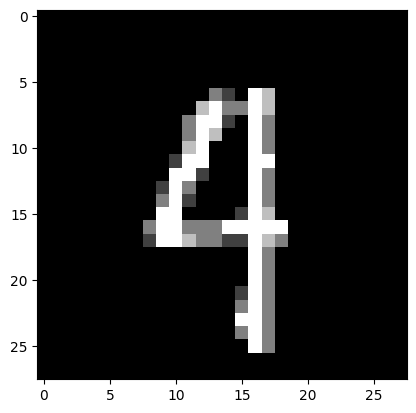

In [4]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [5]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

I0000 00:00:1738696786.724442    4944 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5115 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
W0000 00:00:1738696788.776331    6685 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/hug/.local/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/hug/.local/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/hug/.local/lib/python3.11/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's Debu

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digits (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([5, 8, 4, 1, 5, 5, 8, 8, 5, 4, 8, 1, 5, 8, 5, 5, 1, 8, 4, 5, 5, 8,
       8, 1, 8, 8, 5, 1, 5, 8])

In [7]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

## Question 1

The total number of variables to optimize is : 26,506. Information given by the model.summary() command

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities. 

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [33]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
    
        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [34]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]
        
    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [36]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

np.float32(2.3734133)

# 4. Training the model

In [96]:
def SGD(model, x_train, y_train, learning_rate, epochs=5, batch_size=32, eval_interval=1000):


    number_samples = x_train.shape[0]
    losses= []
    iterations = []
    iteration_count = 0
    
    for epoch in range(epochs):



        indices = np.arange(number_samples)
        np.random.shuffle(indices) 
        

        for i in range(0, number_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            with tf.GradientTape() as tape:
                logits = model(x_batch)
                
                loss_value = tf.reduce_mean(loss(y_batch, logits))
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grads, -learning_rate)  
            
            if iteration_count % eval_interval == 0:
                obj_value = mean_loss(model, x_train, y_train)
                losses.append(obj_value)
                iterations.append(iteration_count)
            
            iteration_count += 1
        
        print(f"Epoch {epoch+1}/{epochs}")
    
    plt.plot(iterations, losses, label=f"LR={learning_rate}")
    plt.xlabel("Iterations")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.title("objective value")
    plt.show()





(60000, 784)
Epoch 1/1


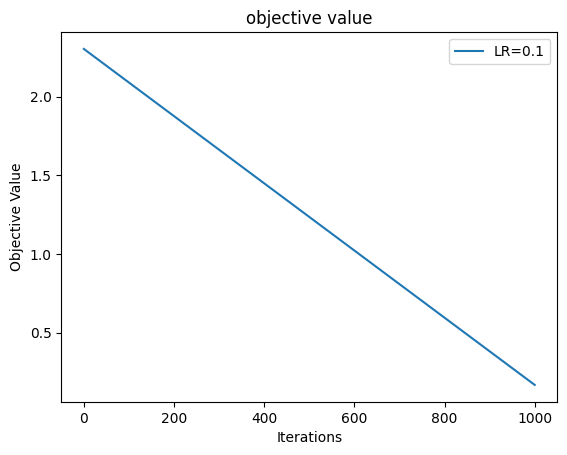

In [100]:
# initialize model

print(x_train.shape)
model = build_model()

with tf.device('/GPU:0'):  
    SGD(model, x_train, y_train, .1, batch_size=32, epochs=1)

(60000, 784)
Epoch 1/1


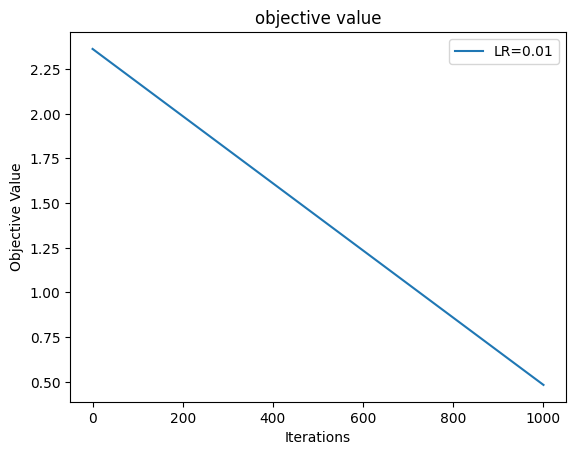

In [101]:
# initialize model

print(x_train.shape)
model = build_model()

with tf.device('/GPU:0'):  
    SGD(model, x_train, y_train, .01, batch_size=32, epochs=1)


(60000, 784)
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


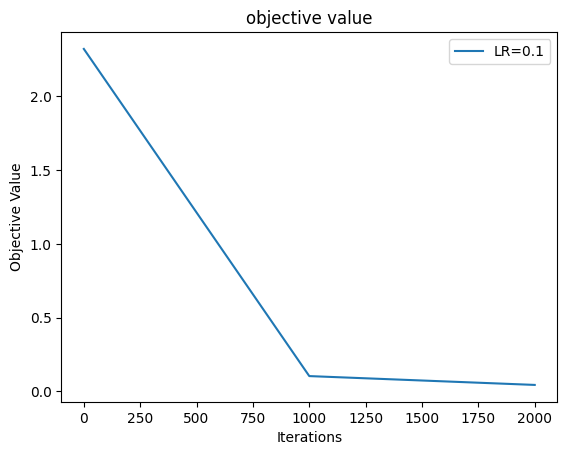

In [97]:
# initialize model

print(x_train.shape)
model = build_model()

with tf.device('/GPU:0'):  
    SGD(model, x_train, y_train, .1, batch_size=128)



(60000, 784)
Epoch 1/5 completed
Epoch 2/5 completed
Epoch 3/5 completed
Epoch 4/5 completed
Epoch 5/5 completed


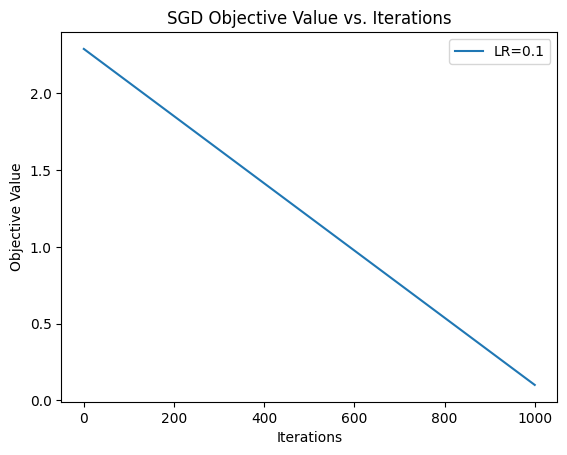

In [93]:
# initialize model

print(x_train.shape)
model = build_model()

with tf.device('/GPU:0'):  
    SGD(model, x_train, y_train, .1, batch_size=256)


## Theoritical questions

The computation on my PC is really expensive. Therefore I directly implemented SGD with batches because it was impossible to compute gradients for each samples. 

The mini-batch technique enables the user to do parallel computation on their GPU for instance, and reduces the time of training. Moreover
we can therefore do more epochs for the same time which is nice. 

In this notebook I consider that a 32 mini batch is used to answer the questions for a 1 mini batch since it is too time consuming 

For a small enough step size the training seems to stall which is amplified with epochs. 